# **BUStools & kallisto workflow:** 10x v2 Dataset 1k Brain Cells from an E18 Mouse
### **Created:** 10 February 2019

*REQUIREMENTS:*
1. [kallisto](https://pachterlab.github.io/kallisto/download)
2. [BUStools](https://github.com/BUStools/bustools)
3. [Mouse Transcriptome](http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_1k_v2/neuron_1k_v2_fastqs.tar)
----------------

In [10]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys, collections, os, argparse
%matplotlib inline  

## **Step 1:** Download the 10x Dataset

10x datasets are available at
https://support.10xgenomics.com/single-cell-gene-expression/datasets

The page for the `1k Brain Cells from an E18 Mouse (v2 chemistry)` dataset is
https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/neuron_1k_v2

You can download the dataset in two ways:
1. Traditional click and download to a specific folder
2. Using terminal commands (wget) (right click the download link on the 10x page and press "copy link"

**Note:** To run terminal commands directly in a Jupyter Notebook, preceed the command with a !, for example ```!ls -l```.

We will download the dataset using terminal commands and save them to the same folder that this Jupyter Notebook is saved to. Here is the link we will use: http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_1k_v2/neuron_1k_v2_fastqs.tar. The FASTQ files are 7.4 GB large.

In [11]:
if not (os.path.isfile('./neuron_1k_v2_fastqs.tar')): 
    !wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_1k_v2/neuron_1k_v2_fastqs.tar
else: print('Dataset already downloaded!')

Dataset already downloaded!


The data is compressed (in the .tar format) so we uncompress it with the following terminal command, and put all of the FASTQ files into a folder called ```neuron_1k_v2_fastqs/```.

In [12]:
!tar -xvf ./neuron_1k_v2_fastqs.tar

neuron_1k_v2_fastqs/
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_I1_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R2_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R1_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R1_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_I1_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R2_001.fastq.gz


## **Step 2:** Download the species transcriptome from Ensembl
**Note:** If you wish to skip **Step 2** through **Step 4** you can download the kallisto index file ```mouse.idx``` and the transcripts to genes file for the mouse ```t2g.txt``` from https://github.com/pachterlab/kallisto-transcriptome-indices/releases. If you have those files in the same folder as this notebook then proceed to **Step 5**. 

The transcriptome is used to build the kallisto index (which allows us to align reads from a single-cell experiment). This step only needs to be done once per species. 

Navigate to ```https://uswest.ensembl.org/info/data/ftp/index.html``` and select mouse cDNA FASTA. Right click on ```Mus_musculus.GRCm38.cdna.all.fa.gz``` and select ```Copy link address```. 

In [13]:
if not (os.path.isfile('Mus_musculus.GRCm38.cdna.all.fa.gz')): 
    !wget ftp://ftp.ensembl.org/pub/release-94/fasta/mus_musculus/cdna/Mus_musculus.GRCm38.cdna.all.fa.gz
else: print('Mouse transcriptome already downloaded!')

--2019-02-10 17:24:08--  ftp://ftp.ensembl.org/pub/release-94/fasta/mus_musculus/cdna/Mus_musculus.GRCm38.cdna.all.fa.gz
           => ‘Mus_musculus.GRCm38.cdna.all.fa.gz’
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.8
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.8|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-94/fasta/mus_musculus/cdna ... done.
==> SIZE Mus_musculus.GRCm38.cdna.all.fa.gz ... 50809568
==> PASV ... done.    ==> RETR Mus_musculus.GRCm38.cdna.all.fa.gz ... done.
Length: 50809568 (48M) (unauthoritative)

100%[======================================>] 50,809,568  3.58MB/s   in 15s    

2019-02-10 17:24:30 (3.18 MB/s) - ‘Mus_musculus.GRCm38.cdna.all.fa.gz’ saved [50809568]



## **Step 3:** Buid the kallisto index

First make sure that kallisto is installed and the version is greater than 0.45. If kallisto is not installed then do so by following the instructions at https://pachterlab.github.io/kallisto/download

In [14]:
!kallisto version 

kallisto, version 0.45.0


The index is built from the published reference transcriptome for each organism (that we downloaded in **Step 2**.
Building the index takes a few minutes and needs to be done only once for each organism.

In [15]:
if not (os.path.isfile('mouse.idx')): 
    !kallisto index -i mouse.idx Mus_musculus.GRCm38.cdna.all.fa.gz
else: print ('Mouse index already exists!')


[build] loading fasta file Mus_musculus.GRCm38.cdna.all.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 600 target sequences
[build] warning: replaced 3 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 711215 contigs and contains 98989067 k-mers 



## **Step 4:** Generate the transcripts to genes file ```t2g.txt```

The file ```t2g.txt``` is a tab separated document that lists the transcripts and the genes that they code for. It is used in **Step 7** for generating the gene count matrix. 

The general format of `t2g.txt` is

```
ENSMUST00000177564.1	ENSMUSG00000096176.1	Trdd2
ENSMUST00000196221.1	ENSMUSG00000096749.2	Trdd1
ENSMUST00000179664.1	ENSMUSG00000096749.2	Trdd1
ENSMUST00000178862.1	ENSMUSG00000094569.1	Trbd2
ENSMUST00000178537.1	ENSMUSG00000095668.1	Trbd1
ENSMUST00000179520.1	ENSMUSG00000094028.1	Ighd4-1
ENSMUST00000179883.1	ENSMUSG00000094552.1	Ighd3-2
.
.
.
```

This file is made automatically with the following terminal commands. By parsing the ```Mus_musculus.GRCm38.cdna.all.fa``` file that was downloaded in **Step 2** we can generate this file.

In [22]:
if not os.path.isfile('t2g.txt'): 
    !gunzip Mus_musculus.GRCm38.cdna.all.fa.gz
    !cat ./Mus_musculus.GRCm38.cdna.all.fa | awk '{if($1~/>/)print $1"\t"$4"\t"$7}' > t2g.txt; sed -i 's/>//g' t2g.txt; sed -i 's/gene://g' t2g.txt; sed -i 's/gene_symbol://g' t2g.txt
else: print('Transcripts to genes file already made!')

Transcripts to genes file already made!


## **Step 5:** Run kallisto BUS
kallisto BUS will take your FASTQ files ```neuron_1k_v2_fastqs``` and the kallisto index ```mouse.idx``` and will generate a folder ```bus_output/``` containing the following files:

```matrix.ec
output.bus
run_info.json
transcripts.txt```. 

kallisto BUS supports several single-cell sequencing technologies. The list of technologies that the current version of kallisto supports is listed below.            

In [23]:
!kallisto bus --list

List of supported single cell technologies

short name       description
----------       -----------
10Xv1            10X chemistry version 1
10Xv2            10X chemistry verison 2
DropSeq          DropSeq
inDrop           inDrop
CELSeq           CEL-Seq
CELSeq2          CEL-Seq version 2
SCRBSeq          SCRB-Seq



We will now run kallisto BUS. This will align the reads from your FASTQ files to the reference transcriptome, using the kallisto index. Note that ```-i``` indicates the kallisto index, ```-o``` indicates the output folder, ```-x``` indicates the single-cell technology that was used to produce the data, and ```-t``` indicates how many threads will be used to perform the computation.

In [4]:
!kallisto bus -i mouse.idx  -o bus_output -x 10xv2 -t 10 \
./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R1_001.fastq.gz \
./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R2_001.fastq.gz \
./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R1_001.fastq.gz \
./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R2_001.fastq.gz


[index] k-mer length: 31
[index] number of targets: 115,270
[index] number of k-mers: 98,989,067
[index] number of equivalence classes: 419,171
[quant] will process sample 1: ./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R1_001.fastq.gz
                               ./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R2_001.fastq.gz
[quant] will process sample 2: ./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R1_001.fastq.gz
                               ./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R2_001.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 104,846,299 reads, 73,297,108 reads pseudoaligned


## **Step 6:** Process the BUS file
Before we continue, make sure that BUStools is installed on your machine. See https://github.com/BUStools/bustools for installation instructions.

The ```output.bus``` file that is created is in binary, for storage size reasons. To work with it, we first convert it to a .txt file. To produce the text file we first sort the ```output.bus``` file and save that sorted file as ```output.sorted.txt``` and then we convert the sorted file to a .txt file.

We discard any barcodes that don't have more 10 UMIs 

In [6]:
!bustools sort -o ./bus_output/output.sorted.bus ./bus_output/output.bus

Read in 73297108 number of busrecords
All sorted


In [7]:
!bustools text -o ./bus_output/output.sorted.txt ./bus_output/output.sorted.bus

Read in 21115457 number of busrecords


## **Step 7:** Process all of the BUS files to generate gene count matrices

From the ```output.sorted.txt``` file we need to generate our gene count matrices. The following python script does this conversion. The four arguments are the ```bus_output/``` directory, the ```t2g.txt``` file, the mininum number of genes to filter by, and the maximum number of genes to filter by. Note that if the ```t2g.txt``` file is not in the ```bus_output/``` folder, then put it there, or reference it by ```../t2g.txt``` when calling this script.

In [1]:
gene_min = 200
gene_max = 10000

#setup working directory
import os
os.chdir("./bus_output/")

from subprocess import call
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, collections

tr2g = {}
trlist = []
with open("../t2g.txt") as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('./matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('./output.sorted.txt') as f:
    gs = set()
    for line in f:
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's update with intersection of genelist
                gl = ec2g(ec)
                gs.intersection_update(gl)
            else:
                # new UMI, process the previous gene set
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gs = set(ec2g(ec))
        else:
            # work with previous gene list
            for g in gs:
                cell_gene[pbar][g] += 1.0/len(gs)
            
            if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                del cell_gene[pbar]
            
            pbar = barcode
            pumi = umi
            
            gs = set(ec2g(ec))

    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]

barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s

#Output a gene count histogram
bcv = [x for b,x in barcode_hist.items() if x > gene_min and x < gene_max]
plt.switch_backend('agg')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(bcv,bins=100)
ax.set_title("Histogram")
plt.xlabel("number of genes detected")
plt.ylabel("number of barcodes")
fig.savefig('gene_hist.png')

outfile = './matrix.mtx'

gene_to_id = dict((g,i+1) for i,g in enumerate(genes))
barcodes_to_use = [b for b,x in barcode_hist.items() if x > gene_min and x < gene_max]

num_entries = 0
for barcode in barcodes_to_use:
    num_entries += len([x for x in cell_gene[barcode].values() if x>0])

with open(outfile, 'w') as of:
    of.write('%%MatrixMarket matrix coordinate real general\n%\n')
    #number of genes
    of.write("%d %d %d\n"%(len(genes), len(barcodes_to_use), round(num_entries)))
    bcid = 0
    for barcode in barcodes_to_use:
        bcid += 1
        cg = cell_gene[barcode]
        gl = [(gene_to_id[g],cg[g]) for g in cg if cg[g] > 0]
        gl.sort()
        for x in gl:
            of.write("%d %d %f\n"%(x[0],bcid,x[1]))

gene_names = {}
with open("../t2g.txt") as f:
    f.readline()
    for line in f:
        t,g,gn = line.split()
        gene_names[g] = gn

id_to_genes = dict((i,g) for (g,i) in gene_to_id.items())
gl = []
for i in range(1,len(genes)+1):
    g = id_to_genes[i]
    gid = g
#    gid = g[:g.find('.')]
    if gid in gene_names:
        gn = gene_names[gid]
    else:
        gn = ''
    gl.append((g,gn))

with open('./genes.tsv','w') as of:
    for g,gn in gl:
        of.write("%s\t%s\n"%(g,gn))
        
with open('./barcodes.tsv','w') as of:
    of.write('\n'.join(x + '' for x in barcodes_to_use))
    of.write('\n')

Take a look at ```gene_hist.png``` generated from this file:

![image](bus_output/gene_hist.png)

## **Step 8:** Downstream analysis

Here we will perform the downstream analysis of the data, following the ScanPy notebook tutorial. 

For help installing scanpy see https://icb-scanpy.readthedocs-hosted.com/en/latest/installation.html

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './neuron_1k_v2.h5ad'

scanpy==1.3.2 anndata==0.6.11 numpy==1.15.3 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [12]:
adata = sc.read('./bus_output/matrix.mtx', cache=True).T  # transpose the data
adata.var_names = pd.read_csv('./bus_output/genes.tsv', delimiter="\t", header=None)[1]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [13]:
adata.var_names_make_unique()

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

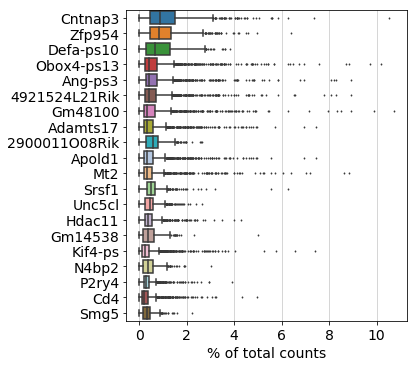

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering (but remember we already did some filtering by min and max number of genes in **Step 7**).

In [15]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_counts=1)

Per-cell normalize (library-size correct) the gene count matrix, so that counts become comparable among cells. Total counts per cell will sum to 1,000 after normalization.

In [19]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

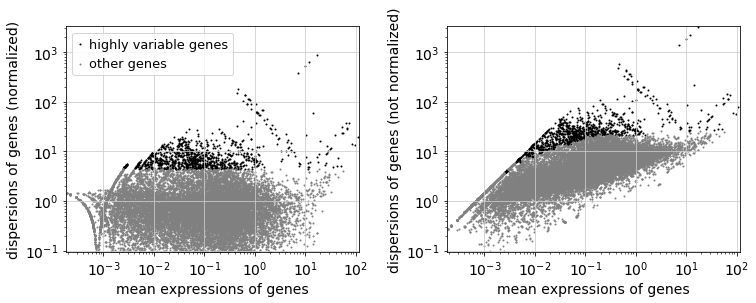

In [21]:
filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.pl.filter_genes_dispersion(filter_result, log=True)

In [22]:
adata = adata[:, filter_result.gene_subset]  # filter genes
sc.pp.normalize_per_cell(adata)  # need to redo normalization after filtering
sc.pp.log1p(adata)  # log transform: X = log(X + 1)
sc.pp.scale(adata)

### Plotting PCA
Compute PCA and make scatter plot

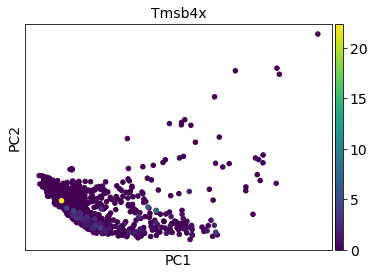

In [24]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='Tmsb4x') # Note that Tmsb4x is the highest expressed gene.

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function ```sc.tl.louvain()``` or tSNE ```sc.tl.tsne()```. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

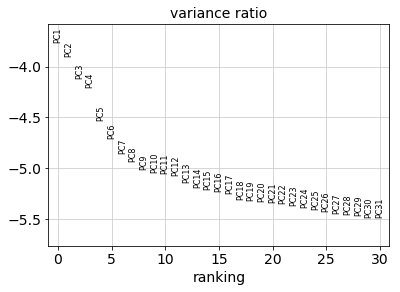

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

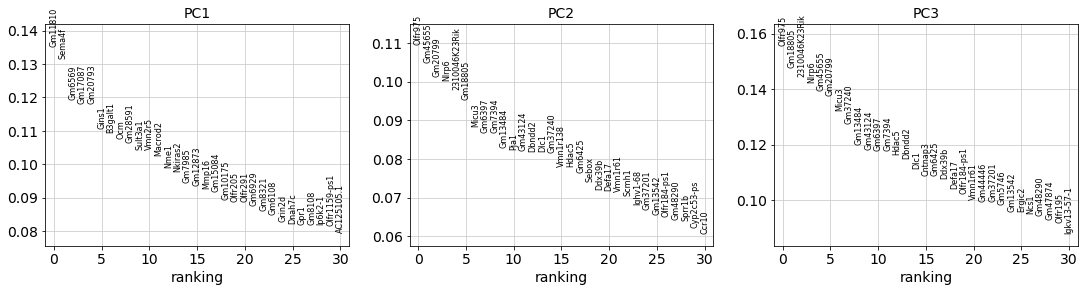

In [26]:
sc.pl.pca_loadings(adata)

In [27]:
adata

AnnData object with n_obs × n_vars = 1469 × 1000 
    obs: 'n_genes', 'n_counts'
    var: 'n_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Plotting TSNE

In [28]:
adata = sc.read(results_file)

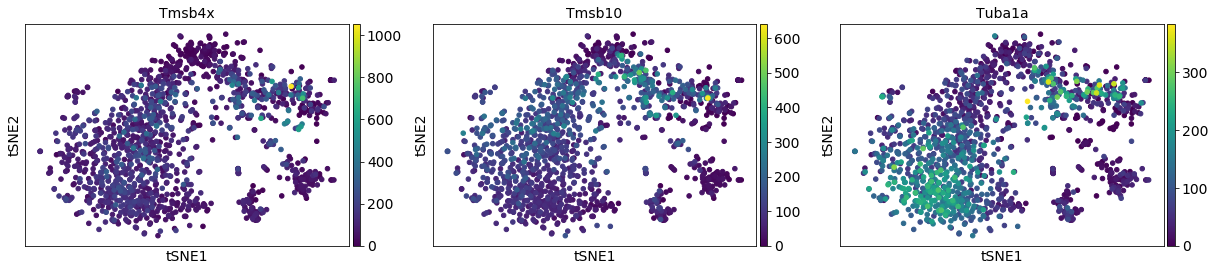

In [29]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=["Tmsb4x", "Tmsb10", "Tuba1a"])

### Plotting UMAP

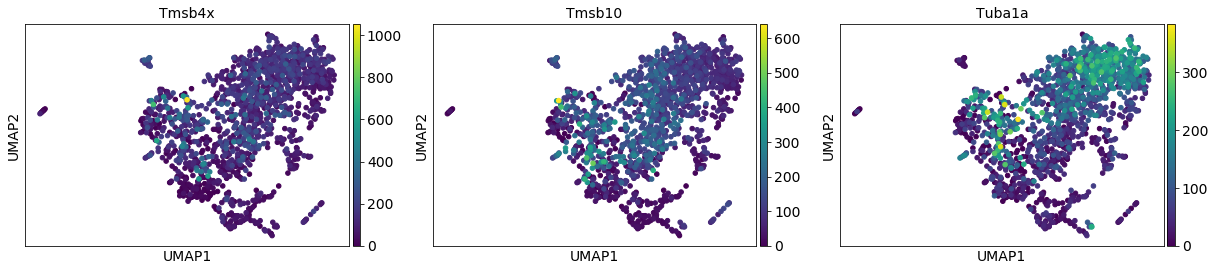

In [30]:
sc.pp.neighbors(adata, n_neighbors=3, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["Tmsb4x", "Tmsb10", "Tuba1a"])

----------------------